[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/casadoj/efas_hydro.git/HEAD?urlpath=%2Fdoc%2Ftree%2F.%2Fnotebook%2Fglofas_calibration.ipynb)

# GloFAS calibration time series

This notebook creates a CSV file with the time series of daily discharge needed for the GloFAS calibration. First, it will extract the gauging stations available in the Hydrologial Data Management Service, and then it will download the discharge time series for those stations. As a result, it produces two ZIP files (_stations.zip_, _timeseries.zip_) that contain, respectively, a shapefile of the station metadata and the CSV file with the discharge time series for the selected stations and period.

You can run the notebook in two ways. Locally, if you have cloned the repository and installed `EFAS_hydro` in your own environment, or virtually using Binder, so you don't need to download nor install anything. To proceed in this second way, click the ![Binder](https://mybinder.org/badge_logo.svg) logo on top; it will launch a notebook environment with all the necessary libraries; the files exported will be saved in the file browser of that virtual environment, so you will need to download them to your local machine.



In [1]:
import getpass
import pandas as pd
from datetime import datetime
from tqdm.auto import tqdm
from pathlib import Path
import shutil

from efashydro.stations import get_stations, plot_stations
from efashydro.timeseries import get_timeseries, plot_timeseries

## Configuration 

In principle, the cell below is the only cell you need to edit in the notebook:

1. Define your **credentials** (`USER` and `PASSWORD`) to be able to access the database.
2. Define the filters used to select **stations**.
   * The `KIND` of station will always be `'river'` in the GloFAS calibration.
   * You can select stations by `COUNTRY_ID` (for instance `'IT'` for Italy), `PROVIDER_ID` or `BASIN_NAME`.
   * Another option is to use a CSV file with a list of the stations of interest. The code will only read the first column in that file, which must contain the station ID in the database; the file must not have a header row. If you're running the notebook in Binder, drag and drop your CSV file into the file browser, so the code has access to it.
4. Define the filters use to extract **time series** information. In principle, you don't need to edit this section, as GloFAS calibrations uses the 24 hour operational weighted (`'nhoperational24hw'`) time series of discharge (`'D'`) from 1980 to 2024.

In [2]:
# HDMS API configuration
USER = input("Enter your HDMS API username:")
PASSWORD = getpass.getpass("Enter your HDMS API password: ")

Enter your HDMS API username: jesus.casado-rodriguez
Enter your HDMS API password:  ········


In [3]:
# station filters
KIND = 'river'
COUNTRY_ID = None
PROVIDER_ID = None
BASIN_NAME = None
STATION_ID = 'stations.csv'

# time series filters
SERVICE = 'nhoperational24hw'
VARIABLE = ['D']
START = '1980-01-01'
END = '2024-01-01'

## `get_stations()`

The following cell extracts the metadata of the stations in the database that pass the filters defined in the [Configuration](#Configuration) section.

Metadata for 9 stations were extracted


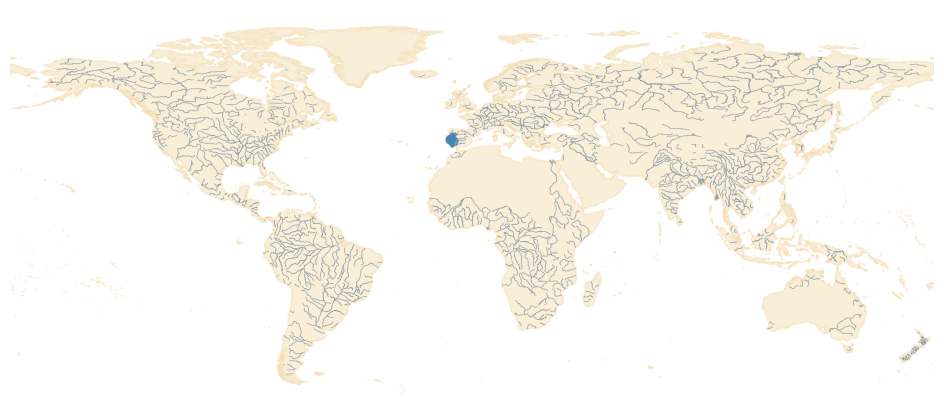

In [4]:
if isinstance(STATION_ID, str):
    STATION_ID = pd.read_csv(STATION_ID, usecols=[0], header=None).squeeze().tolist()

stations = get_stations(
    user=USER, 
    password=PASSWORD, 
    kind=KIND,
    country_id=COUNTRY_ID,
    provider_id=PROVIDER_ID,
    basin_name=BASIN_NAME,
    station_id=STATION_ID,
)
print(f'Metadata for {len(stations)} stations were extracted')

plot_stations(
    geometry=stations.geometry,
    area=stations.CATCH_SKM,
    extent=[-180, 180, -60, 90] # edit to your study area [xmin, xmax, ymin, ymax]
)

The result is a `geopandas.GeoDataFrame` of stations and their metadata. As a `geopandas` object, the stations have associated their geographical location and can be exported to a shapefile to be used in a GIS software.

### Export

The cell below exports the station metadata in two formats (CSV and SHP) in a folder named _./stations/_. This folder is compressed into a **stations.zip** file, so you can easily download the results in case you're running the script in Binder.

In [ ]:
path_stations = Path('./stations/')
path_stations.mkdir(parents=True, exist_ok=True)
filename = 'stations'
if COUNTRY_ID is not None:
    filename += f'_{COUNTRY_ID}'
if PROVIDER_ID is not None:
    filename += f'_{PROVIDER_ID}'

# as shapefile
stations.to_file(path_stations / f'{filename}.shp')
# as CSV
stations.drop('geometry', axis=1).to_csv(path_stations / f'{filename}.csv')

# compress the stations folder
zipfile = shutil.make_archive('stations', 'zip', path_stations)
print(f'You can now download the compressed file {zipfile} from the file browser.')

## `get_timeseries()`

The cell below extracts the daily time series of discharge for the stations selected above. Go to the [Configuration](#Configuration) section if you need to change the settings of the time series extraction: `SERVICE`, `VARIABLE`, `START`, `END`.

In [ ]:
time_series = {}
START, END = [pd.to_datetime(x) for x in [START, END]]
for efas_id in tqdm(stations.index, desc='Stations'):
    time_series[efas_id] = get_timeseries(
        user=USER,
        password=PASSWORD,
        station_id=efas_id,
        service=SERVICE,
        variable=VARIABLE, 
        start=START,
        end=END
    )

The result is a dictionary of `pandas.DataFrames`, where every key is the ID of a station and the value the daily discharge time series available for that station. 

### Export

The individual station time series are concatenated into a single `pandas.DataFrame` that contains the daily discharge time series for all the selected stations in the period from `START` to `END`. If there is no data at the beginning or end of the study period for none of the stations, the CSV file will still contain the whole period.

The concatenated `pandas.DataFrame` is saved as CSV files inside the _./timeseries/_ folder. This folder is compressed into the **timeseries.zip** file to ease the download in case you're running the notebook in Binder.

In [ ]:
path_timeseries = Path('./timeseries/')
path_timeseries.mkdir(parents=True, exist_ok=True)
filename = 'discharge'
if COUNTRY_ID is not None:
    filename += f'_{COUNTRY_ID}'
if PROVIDER_ID is not None:
    filename += f'_{PROVIDER_ID}'

# concatenate all the time series
ts_list = []
for efas_id, df in time_series.items():
    df.columns = [efas_id]
    ts_list.append(df)
ts_df = pd.concat(ts_list, axis=1)

# make sure the time series cover all the period
dates = pd.date_range(START, END, freq='D')
if len(ts_df) != len(dates):
    ts_df = ts_df.reindex(dates)
    ts_df.index.name = 'time'

# save as CSV file
ts_df.to_csv(path_timeseries / f'{filename}.csv')

# compress the time series folder
zipfile = shutil.make_archive('timeseries', 'zip', path_timeseries)
print(f'You can now download the compressed file {zipfile} from the file browser.')

### Compare time series
The following cell creates a line plot that compares the discharge time series of two or more stations. To zoom into some specific period, use the `xlim` argument to define the extent of the X axis in the plot. You can save the plot by defining the name of the output file in the `save` argument.

In [ ]:
# compare timeseries
plot_timeseries(
    ts_df, 
    station_id=None, # list of stations to compare. Ex: [id1, id2, id3]
    xlim=(START, END), # time period to zoom in. Ex: ('2015-01-01', '2015-12-31'),
    ylabel='discharge (m³/s)',
    save=None, # name of the output file Ex: 'discharge.png',
)